In [202]:
# Import general packages
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import time

# Import specific packages
from pandas import read_csv
from numpy import dstack
from numpy import vstack
from numpy import unique
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [259]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def load_file(filepath):
    datafile = read_csv(filepath, header=None, delim_whitespace = True)
    return datafile.values

# The following definition simplifies importing the datafiles
def load_group(filenames, prefix = ''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # Stack the group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

def load_dataset(group, prefix=''):
    filepath = prefix + group + '\\Inertial Signals\\'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '\\y_'+group+'.txt')
    return X, y


def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += int((size / 2))
        
def segment_signal(data,window_size = 128):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data.iloc[start:end,3]
        y = data.iloc[start:end,4]
        z = data.iloc[start:end,5]
        if(len(data["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

# summarize the balance of classes in an output variable column
def class_breakdown(data):
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class = %d, total = %d, percentage = %.3f' % (i+1, counts[i], percent))
        
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

def plot_subject(X, y):
    plt.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left')
    plt.show()
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def evaluate_model(trainX, trainy, testX, testy):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    mc = ModelCheckpoint('best_model', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    
    verbose, epochs, batch_size = 0, 1000, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=15, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks = [es, mc], validation_data = (X_val, y_val))
    # evaluate model
    saved_model = load_model('best_model')
    _, train_acc = saved_model.evaluate(trainX, trainy, batch_size=batch_size, verbose = verbose)
    _, test_acc = saved_model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return train_acc, test_acc, history, saved_model

def test_model(testX, testy, model):
    verbose, batch_size = 0, 64
    _, test_acc = model.evaluate(testX, testy, batch_size=batch_size, verbose = verbose)
    print('Test: %.3f' % test_acc)
    return test_acc

def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def summarize_results(scores):
    print("The model is evaluated a total of 10 times, resulting in the following accuracies:")
    print()
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print()
    print("The mean accuracy with standard deviation is:")
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

### Load all the training and testing datafiles

In [261]:
filenames = ["body_acc_x_train.txt", "body_acc_y_train.txt", "body_acc_z_train.txt", "body_gyro_x_train.txt",
            "body_gyro_y_train.txt", "body_gyro_z_train.txt", "total_acc_x_train.txt", "total_acc_y_train.txt", 
            "total_acc_z_train.txt"]
body_acc = load_group(filenames[0:3], prefix = "C:\\Users\\Administrator\\Desktop\\DSE\\Semester_2\\Deep_Learning\\Paper\\Datafiles\\train\\Inertial Signals\\")
body_gyro = load_group(filenames[3:6], prefix = "C:\\Users\\Administrator\\Desktop\\DSE\\Semester_2\\Deep_Learning\\Paper\\Datafiles\\train\\Inertial Signals\\")
total_acc = load_group(filenames[6:9], prefix = "C:\\Users\\Administrator\\Desktop\\DSE\\Semester_2\\Deep_Learning\\Paper\\Datafiles\\train\\Inertial Signals\\")

X_train, y_train = load_dataset('train', 'C:\\Users\\Administrator\\Desktop\\DSE\\Semester_2\\Deep_Learning\\Paper\\Datafiles\\')
X_train = X_train[:, :, :3]
X_test, y_test = load_dataset('test', 'C:\\Users\\Administrator\\Desktop\\DSE\\Semester_2\\Deep_Learning\\Paper\\Datafiles\\')
X_test = X_test[:, :, :3]

X_val = X_train[int(round(X_train.shape[0]*0.8, 0)):,:,:]
y_val = y_train[int(round(y_train.shape[0]*0.8, 0)):,:]
X_train = X_train[:int(round(X_train.shape[0]*0.8, 0)),:,:]
y_train = y_train[:int(round(y_train.shape[0]*0.8, 0)),:]

train_info = load_file(r'C:\Users\Administrator\Desktop\DSE\Semester_2\Deep_Learning\Paper\Datafiles\train\y_train.txt')
test_info = load_file(r'C:\Users\Administrator\Desktop\DSE\Semester_2\Deep_Learning\Paper\Datafiles\test\y_test.txt')

### Some descriptives on the single imported datafile
##### The data used contains information on inertial signals, i.e. gravitational acceleration (total_acc), body acceleration (body_acc) and body gyroscope (body_gyro). It has data on 3-dimensions: X, Y and Z. The values are scaled to the range (-1, 1).

In [263]:
print("Each training set has the following shape", body_acc.shape)
print("Hence it consists of", total_acc.shape[0], "rows,", total_acc.shape[1], "columns, and", 
     total_acc.shape[2], "layers")

Each training set has the following shape (7352, 128, 3)
Hence it consists of 7352 rows, 128 columns, and 3 layers


In [264]:
train_proportion = round(((X_train.shape[0] + X_val.shape[0])/(X_train.shape[0] +X_val.shape[0] + X_test.shape[0]))*100, 1)
print("The train/test split as follows:")
print("Train proportion:", train_proportion, "%")
print("Test proportion:", round(100 - train_proportion, 1), "%")

The train/test split as follows:
Train proportion: 71.4 %
Test proportion: 28.6 %


In [265]:
print("The training dataset has the following distribution of the labels:")
print()
class_breakdown(train_info)
print()

print("The test dataset has the following distribution of the labels:")
print()
class_breakdown(test_info)
print()

print("Combined, this looks as follows:")
print()
class_breakdown(vstack((train_info, test_info)))

The training dataset has the following distribution of the labels:

Class = 1, total = 1226, percentage = 16.676
Class = 2, total = 1073, percentage = 14.595
Class = 3, total = 986, percentage = 13.411
Class = 4, total = 1286, percentage = 17.492
Class = 5, total = 1374, percentage = 18.689
Class = 6, total = 1407, percentage = 19.138

The test dataset has the following distribution of the labels:

Class = 1, total = 496, percentage = 16.831
Class = 2, total = 471, percentage = 15.982
Class = 3, total = 420, percentage = 14.252
Class = 4, total = 491, percentage = 16.661
Class = 5, total = 532, percentage = 18.052
Class = 6, total = 537, percentage = 18.222

Combined, this looks as follows:

Class = 1, total = 1722, percentage = 16.720
Class = 2, total = 1544, percentage = 14.992
Class = 3, total = 1406, percentage = 13.652
Class = 4, total = 1777, percentage = 17.254
Class = 5, total = 1906, percentage = 18.507
Class = 6, total = 1944, percentage = 18.876


#### Hence, the dataset is fairly distributed among the 6 identifiable activities, both for the train and the test set

# Triaxial 'total accelerometer data'

In [267]:
y_train_df = pd.DataFrame(y_train, columns = ['Category'])
y_train_df['Label'] = 0
for i in range(0, len(y_train_df + 1)):
    if y_train_df.iloc[i, 0] == 1:
        y_train_df.iloc[i, 1] = "Walking"
    elif y_train_df.iloc[i, 0] == 2:
        y_train_df.iloc[i, 1] = "Walking Upstairs"
    elif y_train_df.iloc[i, 0] == 3:
        y_train_df.iloc[i, 1] = "Walking Downstairs"
    elif y_train_df.iloc[i, 0] == 4:
        y_train_df.iloc[i, 1] = "Sitting"
    elif y_train_df.iloc[i, 0] == 5:
        y_train_df.iloc[i, 1] = "Standing"
    else:
        y_train_df.iloc[i, 1] = "Laying"

y_val_df = pd.DataFrame(y_val, columns = ['Category'])
y_val_df['Label'] = 0
for i in range(0, len(y_val_df + 1)):
    if y_val_df.iloc[i, 0] == 1:
        y_val_df.iloc[i, 1] = "Walking"
    elif y_val_df.iloc[i, 0] == 2:
        y_val_df.iloc[i, 1] = "Walking Upstairs"
    elif y_val_df.iloc[i, 0] == 3:
        y_val_df.iloc[i, 1] = "Walking Downstairs"
    elif y_val_df.iloc[i, 0] == 4:
        y_val_df.iloc[i, 1] = "Sitting"
    elif y_val_df.iloc[i, 0] == 5:
        y_val_df.iloc[i, 1] = "Standing"
    else:
        y_val_df.iloc[i, 1] = "Laying"

y_test_df = pd.DataFrame(y_test, columns = ['Category'])
y_test_df['Label'] = 0
for i in range(0, len(y_test_df + 1)):
    if y_test_df.iloc[i, 0] == 1:
        y_test_df.iloc[i, 1] = "Walking"
    elif y_test_df.iloc[i, 0] == 2:
        y_test_df.iloc[i, 1] = "Walking Upstairs"
    elif y_test_df.iloc[i, 0] == 3:
        y_test_df.iloc[i, 1] = "Walking Downstairs"
    elif y_test_df.iloc[i, 0] == 4:
        y_test_df.iloc[i, 1] = "Sitting"
    elif y_test_df.iloc[i, 0] == 5:
        y_test_df.iloc[i, 1] = "Standing"
    else:
        y_test_df.iloc[i, 1] = "Laying"
        
y_train = y_train_df['Category'].astype('float32')
y_val = y_val_df['Category'].astype('float32')
y_test = y_test_df['Category'].astype('float32')

for i in range(0, len(y_train)):
    y_train[i] = y_train[i] - 1
    
for i in range(0, len(y_val)):
    y_val[i] = y_val[i] - 1
    
for i in range(0, len(y_test)):
    y_test[i] = y_test[i] - 1
    
# Note one-hot-encoding for the test labels
X_train = X_train.astype('float32')
y_train = np_utils.to_categorical(y_train, 6)

X_val = X_val.astype('float32')
y_val = np_utils.to_categorical(y_val, 6)

X_test = X_test.astype('float32')
y_test = np_utils.to_categorical(y_test, 6)

num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
input_shape = (num_time_periods*num_sensors)
LABELS = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

X_train_rs = X_train.reshape(X_train.shape[0], input_shape)
X_val_rs = X_val.reshape(X_val.shape[0], input_shape)
X_test_rs = X_test.reshape(X_test.shape[0], input_shape)
print("X_train shape:", X_train.shape)
print('X_train_rs shape:', X_train_rs.shape)
print()
print("X val shape:", X_val.shape)
print("X_val_rs shape:", X_val_rs.shape)
print()
print("X_test shape:", X_test.shape)
print("X_test_rs shape:", X_test_rs.shape)
print('Input shape:', input_shape)

X_train shape: (5882, 128, 3)
X_train_rs shape: (5882, 384)

X val shape: (1470, 128, 3)
X_val_rs shape: (1470, 384)

X_test shape: (2947, 128, 3)
X_test_rs shape: (2947, 384)
Input shape: 384


In [ ]:
for activity in np.unique(y_train_df["Label"]):
    subset = y_train_df[y_train_df["Label"] == activity][:128]
    plot_activity(activity,subset)

# Let's create a DNN Model

In [135]:
epochs, batchsize, verbose = 100, 64, 1
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

In [136]:
y_train_acc = y_train_df['Category'].astype('float32')
for i in range(0, len(y_train_acc)):
    y_train_acc[i] = y_train_acc[i] - 1
    
y_val_acc = y_val_df['Category'].astype('float32')
for i in range(0, len(y_val_acc)):
    y_val_acc[i] = y_val_acc[i] - 1

y_test_acc = y_test_df["Category"].astype("float32")
for i in range (0, len(y_test_acc)):
    y_test_acc[i] = y_test_acc[i] - 1

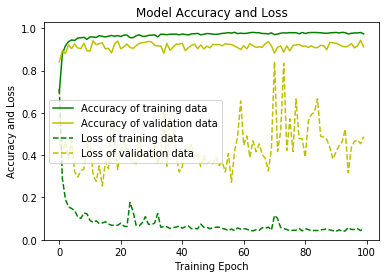

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'g', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'y', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'g--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'y--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# How does it run on the left-out test data?

Epoch 00136: early stopping
>#1 train acc: 96.447
>#1 test acc: 84.425
Epoch 00115: early stopping
>#2 train acc: 96.481
>#2 test acc: 83.848
Epoch 00181: early stopping
>#3 train acc: 97.280
>#3 test acc: 89.990
Confusion matrix of train set


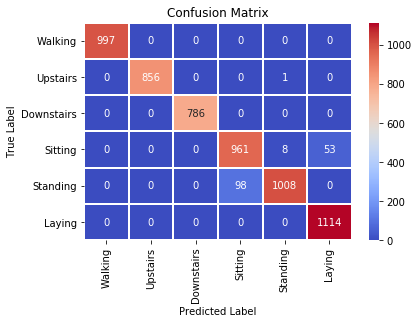

Confusion matrix of test set


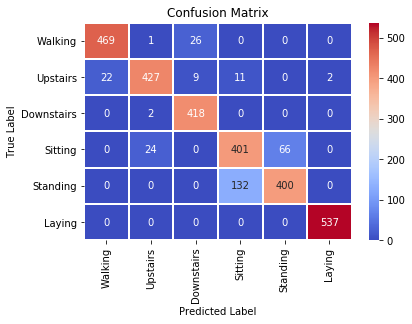

Classification report of train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00       857
           2       1.00      1.00      1.00       786
           3       0.91      0.94      0.92      1022
           4       0.99      0.91      0.95      1106
           5       0.95      1.00      0.98      1114

   micro avg       0.97      0.97      0.97      5882
   macro avg       0.98      0.98      0.97      5882
weighted avg       0.97      0.97      0.97      5882

Classification report of test set
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       496
           1       0.94      0.91      0.92       471
           2       0.92      1.00      0.96       420
           3       0.74      0.82      0.77       491
           4       0.86      0.75      0.80       532
           5       1.00      1.00      1.00       537

   micro

In [241]:
train_acc_ls = list()
test_acc_ls = list()
histories = list()

for r in range(3):
    train_acc, test_acc, history, modely = evaluate_model(X_train, y_train, X_test, y_test)
    train_acc = train_acc * 100.0
    test_acc = test_acc * 100.0
    print('>#%d train acc: %.3f' % (r+1, train_acc))
    print('>#%d test acc: %.3f' % (r+1, test_acc))
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)
    
y_train_pred = modely.predict(X_train)
y_test_pred = modely.predict(X_test)

max_y_train_pred = np.argmax(y_train_pred, axis=1)
max_y_train = np.argmax(y_train, axis=1)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print("Confusion matrix of train set")
show_confusion_matrix(max_y_train, max_y_train_pred)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of train set")
print(classification_report(max_y_train, max_y_train_pred))   

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   

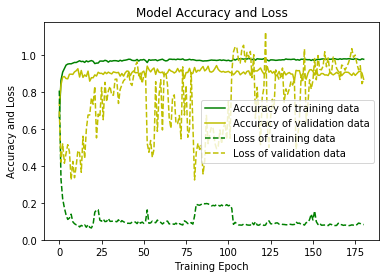

In [242]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'g', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'y', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'g--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'y--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [175]:
summarize_results(test_acc_ls)

The model is evaluated a total of 10 times, resulting in the following accuracies:

[86.25721072276892, 88.22531387852052, 87.27519511367493]

The mean accuracy with standard deviation is:
Accuracy: 87.253% (+/-0.804)


# So training accuracy is about 95%, and testing accuracy is about 85%

# Let's add noise to the training

In [176]:
noise_1 = np.random.normal(0,.20,(len(X_test), 128, 3))
noise_2 = np.random.normal(0,.30,(len(X_test), 128, 3))
noise_3 = np.random.normal(0,.40,(len(X_test), 128, 3))

X_test_noise_1 = X_test + noise_1
X_test_noise_2 = X_test + noise_2
X_test_noise_3 = X_test + noise_3

# Run the model for noise 1

Test: 0.695
>#10 test acc: 69.460
Confusion matrix of train set


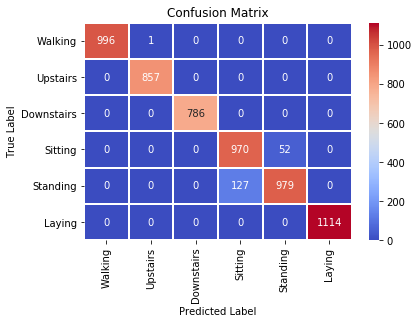

Confusion matrix of test set


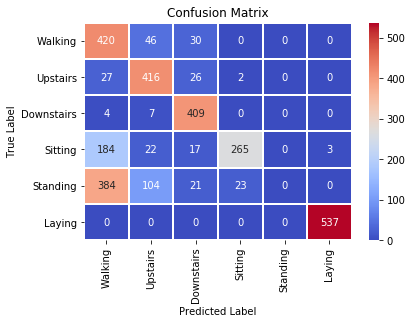

Classification report of train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       997
           1       1.00      1.00      1.00       857
           2       1.00      1.00      1.00       786
           3       0.88      0.95      0.92      1022
           4       0.95      0.89      0.92      1106
           5       1.00      1.00      1.00      1114

   micro avg       0.97      0.97      0.97      5882
   macro avg       0.97      0.97      0.97      5882
weighted avg       0.97      0.97      0.97      5882

Classification report of test set
              precision    recall  f1-score   support

           0       0.41      0.85      0.55       496
           1       0.70      0.88      0.78       471
           2       0.81      0.97      0.89       420
           3       0.91      0.54      0.68       491
           4       0.00      0.00      0.00       532
           5       0.99      1.00      1.00       537

   micro

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [181]:
test_acc = test_model(X_test_noise_1, y_test, modely)
test_acc = test_acc * 100.0
print('>#%d test acc: %.3f' % (r+1, test_acc))

y_train_pred = modely.predict(X_train)
y_test_pred = modely.predict(X_test_noise_1)

max_y_train_pred = np.argmax(y_train_pred, axis=1)
max_y_train = np.argmax(y_train, axis=1)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   

# Run the model for noise 2

Test: 0.652
>#10 test acc: 65.151
Confusion matrix of test set


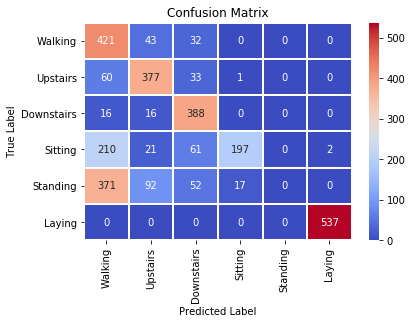

Classification report of test set
              precision    recall  f1-score   support

           0       0.39      0.85      0.53       496
           1       0.69      0.80      0.74       471
           2       0.69      0.92      0.79       420
           3       0.92      0.40      0.56       491
           4       0.00      0.00      0.00       532
           5       1.00      1.00      1.00       537

   micro avg       0.65      0.65      0.65      2947
   macro avg       0.61      0.66      0.60      2947
weighted avg       0.61      0.65      0.60      2947



C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [183]:
test_acc = test_model(X_test_noise_2, y_test, modely)
test_acc = test_acc * 100.0
print('>#%d test acc: %.3f' % (r+1, test_acc))

y_train_pred = modely.predict(X_train)
y_test_pred = modely.predict(X_test_noise_2)

max_y_train_pred = np.argmax(y_train_pred, axis=1)
max_y_train = np.argmax(y_train, axis=1)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   

# Run the model for noise 3

Test: 0.584
>#10 test acc: 58.432
Confusion matrix of test set


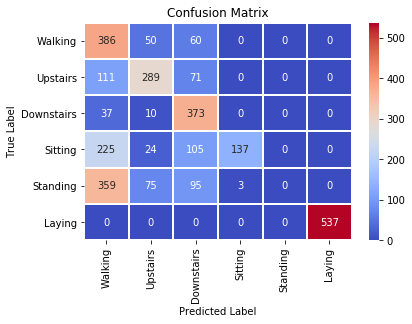

Classification report of test set
              precision    recall  f1-score   support

           0       0.35      0.78      0.48       496
           1       0.65      0.61      0.63       471
           2       0.53      0.89      0.66       420
           3       0.98      0.28      0.43       491
           4       0.00      0.00      0.00       532
           5       1.00      1.00      1.00       537

   micro avg       0.58      0.58      0.58      2947
   macro avg       0.58      0.59      0.53      2947
weighted avg       0.58      0.58      0.53      2947



C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [184]:
test_acc = test_model(X_test_noise_3, y_test, modely)
test_acc = test_acc * 100.0
print('>#%d test acc: %.3f' % (r+1, test_acc))

y_train_pred = modely.predict(X_train)
y_test_pred = modely.predict(X_test_noise_3)

max_y_train_pred = np.argmax(y_train_pred, axis=1)
max_y_train = np.argmax(y_train, axis=1)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   

# Upshift

In [244]:
upshift = 0.2
X_test_upshift = X_test + upshift

test_acc = test_model(X_test_upshift, y_test, modely)
test_acc = test_acc * 100.0
print('>#%d test acc: %.3f' % (r+1, test_acc))

y_train_pred = modely.predict(X_train)
y_test_pred = modely.predict(X_test_upshift)

max_y_train_pred = np.argmax(y_train_pred, axis=1)
max_y_train = np.argmax(y_train, axis=1)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   

KeyboardInterrupt: 

# WISDM Dataset

In [253]:
testset = read_data(r'C:\Users\Administrator\Desktop\DSE\Semester_2\Deep_Learning\Paper\Datafiles\WISDM_ar_v1.1\WISDM_ar_v1.1_raw.txt')
wisdm = testset.replace({';':''}, regex=True)

z_axis = [float(i) for i in wisdm["z-axis"]]
wisdm["z-axis"] = z_axis

# Normalizing features
wisdm['x-axis'] = feature_normalize(wisdm["x-axis"])
wisdm['y-axis'] = feature_normalize(wisdm['y-axis'])
wisdm['z-axis'] = feature_normalize(wisdm['z-axis'])

# Remove irrelevant activities
wisdm = wisdm[wisdm["activity"] != "Jogging"]

activity_dict = {"Downstairs": 2,
                "Sitting": 3,
                "Standing": 4,
                "Upstairs": 1,
                "Walking": 0}

#wisdm["y_cat"] = wisdm["activity"].map(activity_dict)
#wisdm_target = wisdm["activity"].map(activity_dict)
wisdm_input = wisdm.loc[:,["x-axis", "y-axis", "z-axis"]]

wisdm = wisdm.reset_index(drop=True)

print("wisdm has shape:", wisdm.shape)
print("input has shape:", wisdm_target.shape)
print("target has shape:", wisdm_input.shape)

wisdm has shape: (756028, 6)
input has shape: (756028,)
target has shape: (756028, 3)


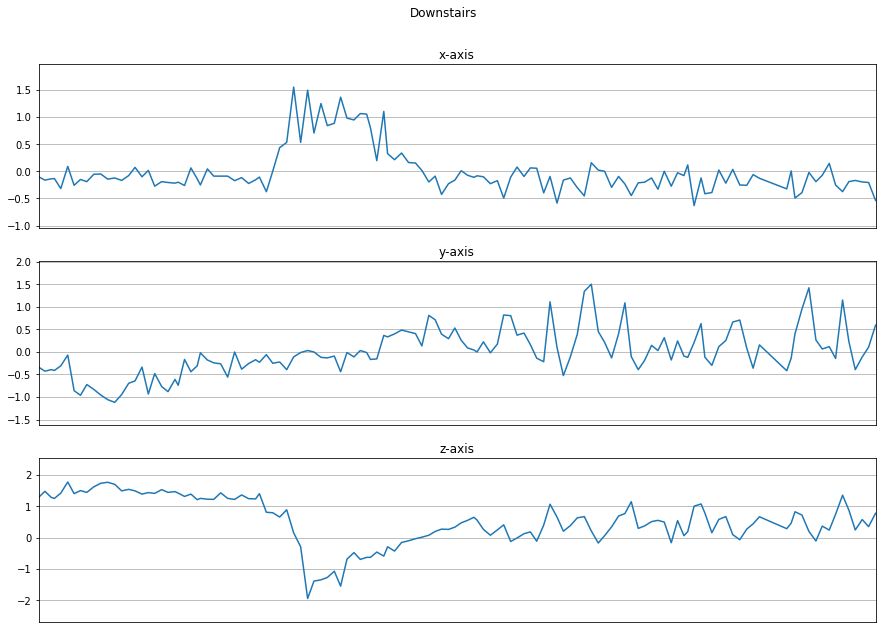

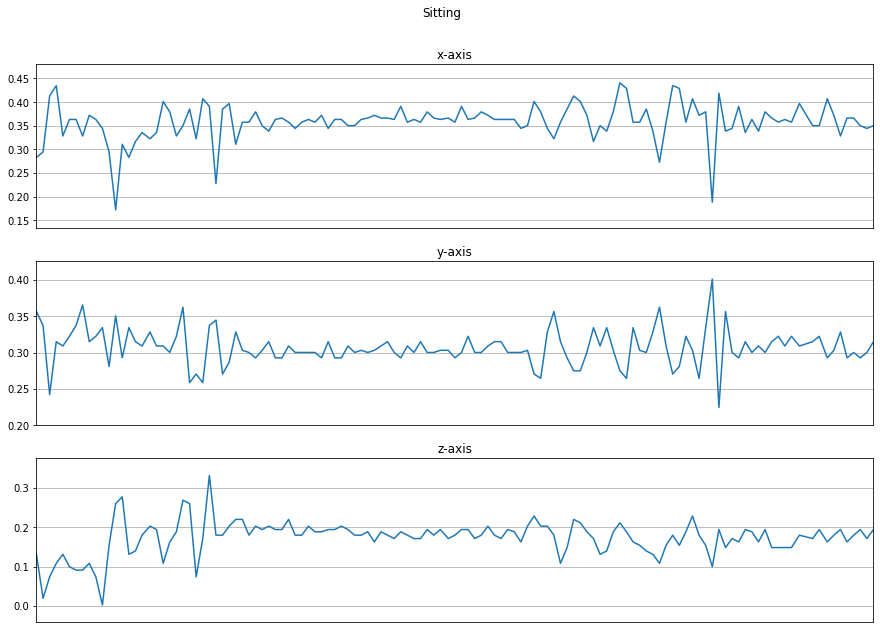

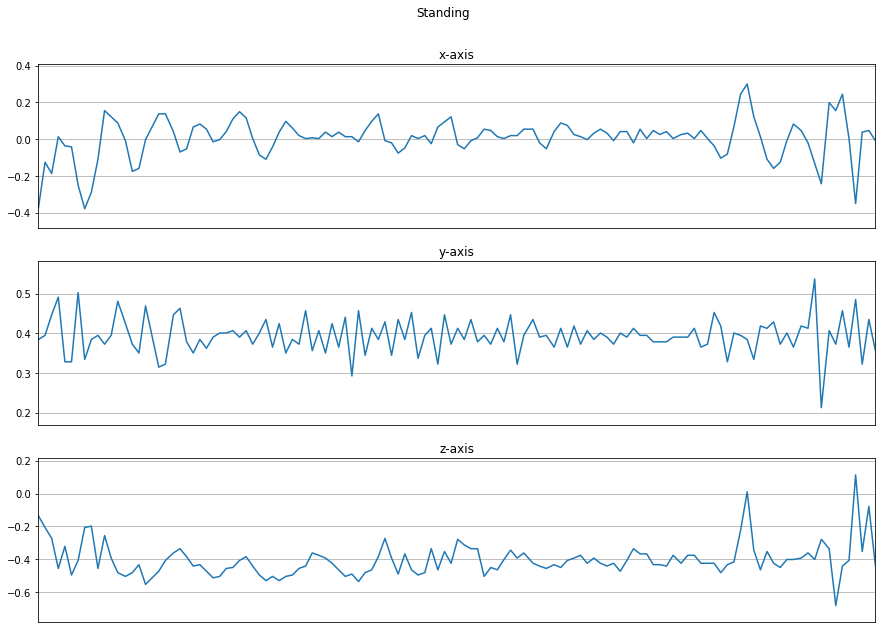

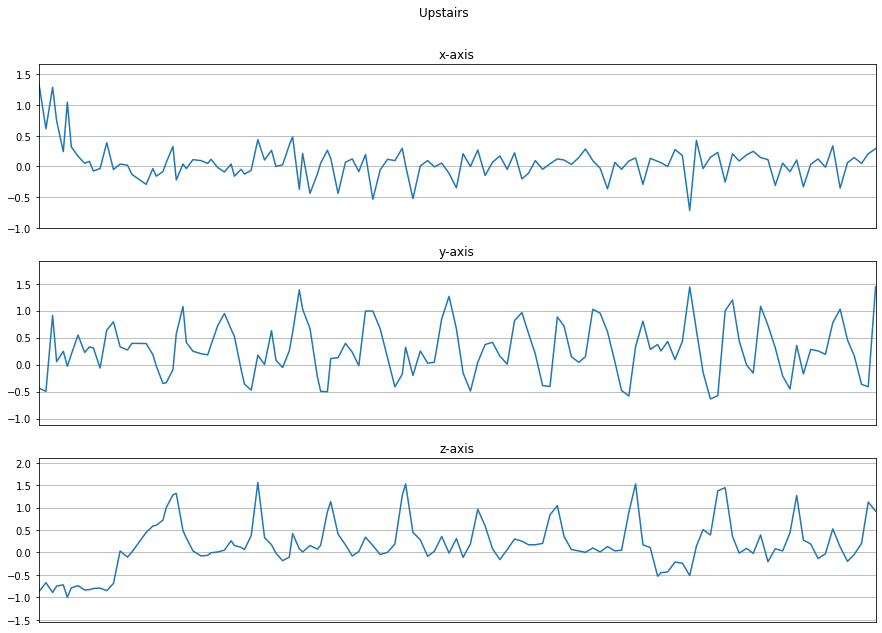

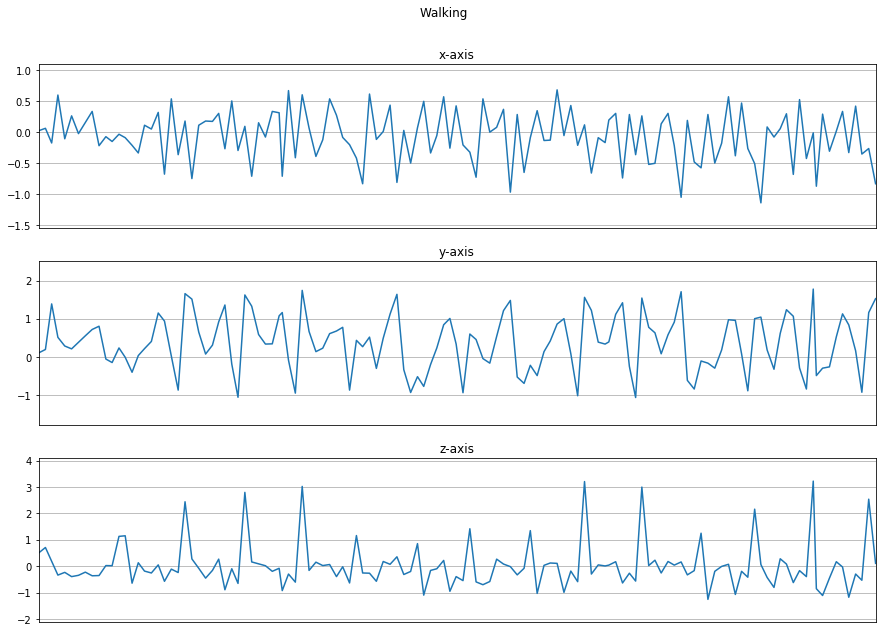

In [260]:
for activity in np.unique(wisdm["activity"]):
    subset = wisdm[wisdm["activity"] == activity][:128]
    plot_activity(activity,subset)

In [249]:
wisdm["activity"].value_counts()

Walking       424398
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [203]:
start_time = time.time()
segments, labels = segment_signal(wisdm)
end_time = time.time()
print("The reshaping of the data took", end_time - start_time, "seconds")

labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments),128, 3)

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


The reshaping of the data took 179.1366262435913 seconds


In [227]:
upd_labels = np.insert(labels, 5, 0, axis = 1)

Test: 0.033
>#10 test acc: 3.344
Confusion matrix of test set


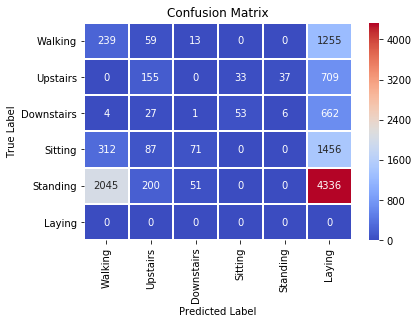

Classification report of test set
              precision    recall  f1-score   support

           0       0.09      0.15      0.11      1566
           1       0.29      0.17      0.21       934
           2       0.01      0.00      0.00       753
           3       0.00      0.00      0.00      1926
           4       0.00      0.00      0.00      6632
           5       0.00      0.00      0.00         0

   micro avg       0.03      0.03      0.03     11811
   macro avg       0.07      0.05      0.05     11811
weighted avg       0.04      0.03      0.03     11811



C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [230]:
test_acc = test_model(segments, upd_labels, modely)
test_acc = test_acc * 100.0
print('>#%d test acc: %.3f' % (r+1, test_acc))

y_test_pred = modely.predict(segments)
max_y_test_pred = np.argmax(y_test_pred, axis=1)
max_y_test = np.argmax(labels, axis=1)

print("Confusion matrix of test set")
show_confusion_matrix(max_y_test, max_y_test_pred)

print("Classification report of test set")
print(classification_report(max_y_test, max_y_test_pred))   